# SBI Toolbox

In [1]:
import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, SNLE, SNPE_C, SNRE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

## Flexible interface

Behind the scenes of each method happens (see figure):

1. sampling parameters from the prior followed by simulating synthetic data from these parameters

2. learning the (probabilistic) association between data (or data features) and underlying parameters, i.e. to learn statistical inference from simulated data. The way in which this association is learned differs between the above methods, but all use deep neural networks.

3. This learned neural network is then applied to empirical data to derive the full space of parameters consistent with the data and the prior, i.e. the posterior distribution. High posterior probability is assigned to parameters which are consistent with both the data and the prior, low probability to inconsistent parameters. While SNPE directly learns the posterior distribution, SNLE and SNRE need an extra MCMC sampling step to construct a posterior.

4. If needed, an initial estimate of the posterior can be used to adaptively generate additional informative simulations.



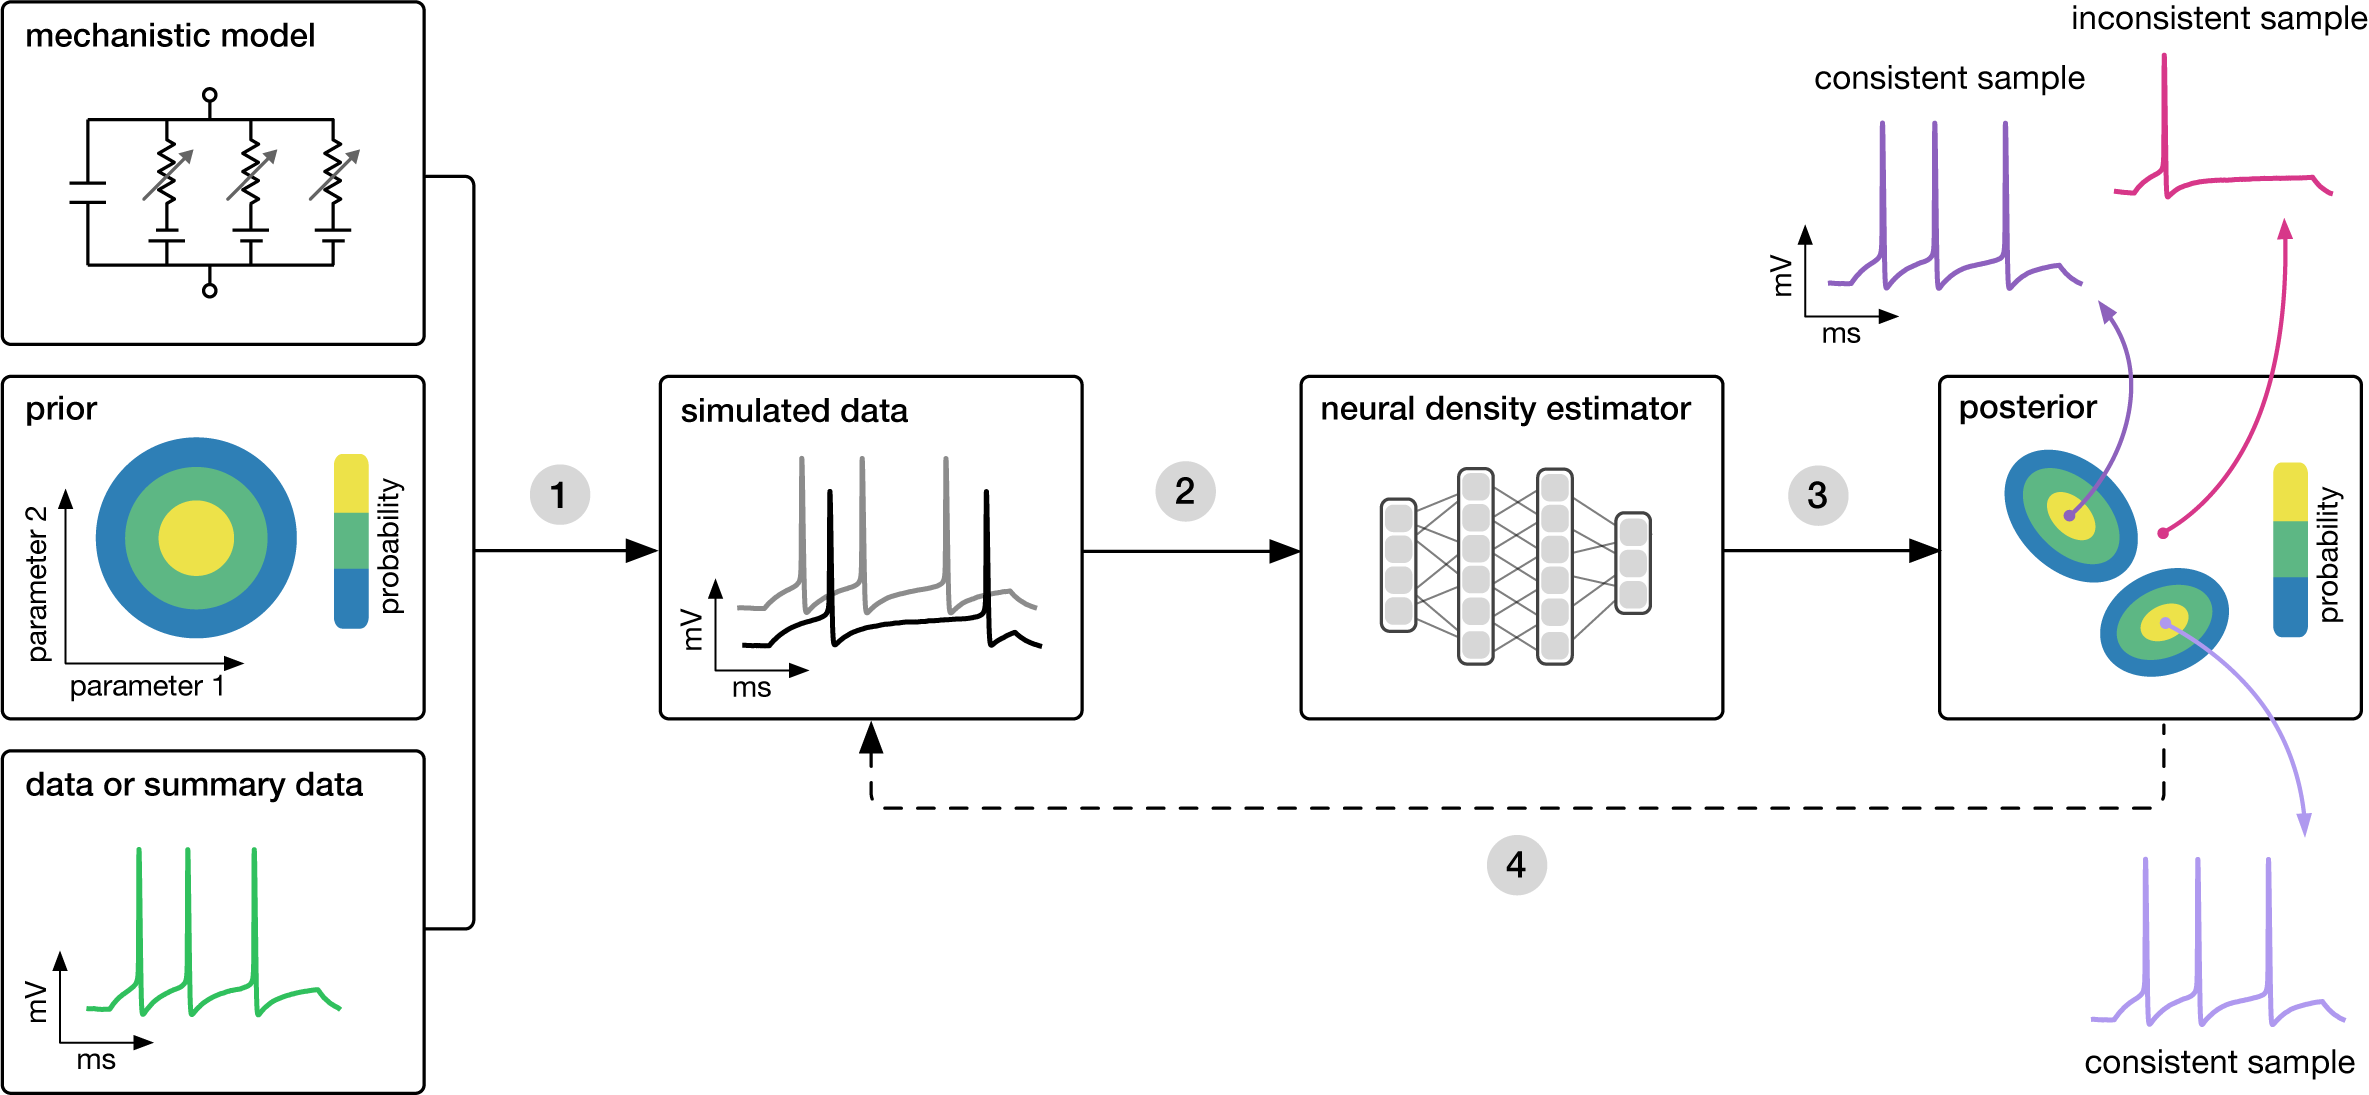

#### 0. Basic ingredients

For inference, you need to provide two ingredients:

1) a **prior** distribution that allows to sample parameter sets.
2) a **simulator (e.g., mechanistic model)** that takes parameter sets and produces simulation outputs.

For example, we can have a 3-dimensional parameter space with a uniform prior between [-2,2] and a simple simulator that for the sake of example adds 1.0 and some Gaussian noise to the parameter set (i.e., $s(\theta) = 1 + \theta + 0.1\epsilon$):

In [2]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(theta):
    return 1 + theta + 0.1 * torch.randn(theta.shape) ##### INSERT YOUR CODE HERE #####

#### 1. Simulate data

In [3]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

#### 2. Pass the simulated data to the inference object

In [4]:
# theta and x should both be a torch.Tensor of type float32
inference = SNPE(prior=prior)
inference = inference.append_simulations(theta, x)
# Next, we train the neural density estimator.
density_estimator = inference.train()

 Neural network successfully converged after 80 epochs.

#### 3. Build the posterior object from trained density


In [5]:
posterior = inference.build_posterior(density_estimator)

Let’s say we have made some observation x = {0, 0, 0}. 

In [6]:
# choose true parameters and sample
x_true = ##### INSERT YOUR CODE HERE #####

So in each dimension:  $0 = 1 + \theta + 0.1\epsilon$. What should $\theta$ be? 

Let's this observation, we can then sample from the posterior $p(θ|x)$, evaluate its log-probability, or plot it.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

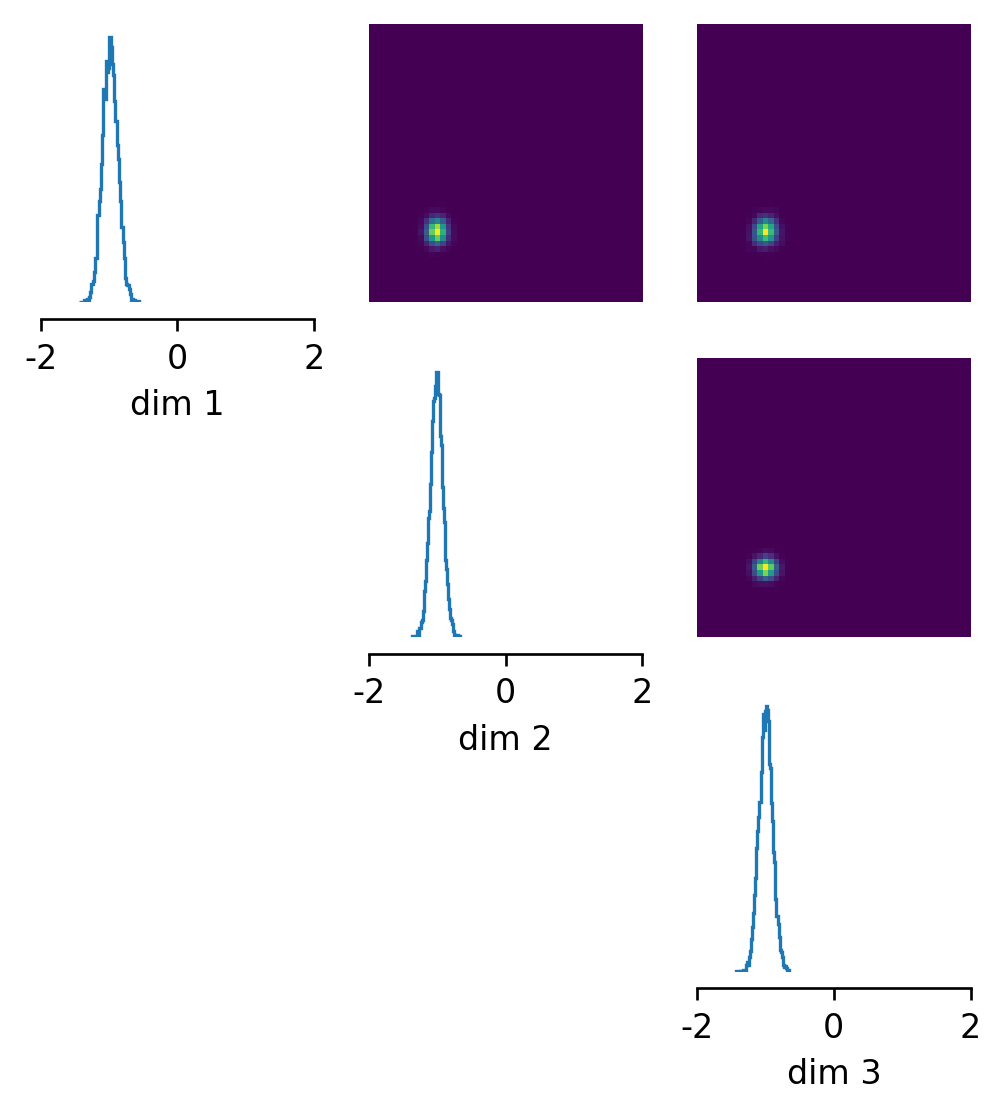

In [9]:
# get posterior samples for the observation of interest
posterior_samples = posterior.sample((10000,), x=x_true)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)

In [10]:
density_consistent_sample = posterior.log_prob(x=x_true, theta=torch.tensor([-1.0, -1.0, -1.0]))
density_consistent_sample

tensor([4.1450])

In [11]:
density_inconsistent_sample = posterior.log_prob(x=x_true, theta=torch.tensor([1.0, 1.0, 1.0]))
density_inconsistent_sample

tensor([-491.7665])

In [12]:
# We can always print the posterior to know how it was trained:
print(posterior)

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


#### It's amortized!

We can evaluate the posterior for different observations without having to re-run inference. This is called **amortization**. An amortized posterior is one that is not focused on any particular observation. Naturally, if the diversity of observations is large, any of the inference methods will need to run a sufficient number of simulations for the resulting posterior to perform well across these diverse observations.

Let’s say we have not just one but two observations 
$x_{obs1}$ and $x_{obs2}$ for which we aim to do parameter inference.

In [54]:
# generate the first observation
theta_1 = prior.sample((1,))
x_obs_1 = simulator(theta_1)
# now generate a second observation
theta_2 = prior.sample((1,))
x_obs_2 = simulator(theta_2)

We can directly draw samples from the posterior given $x_{obs1}$ and then plot them:

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

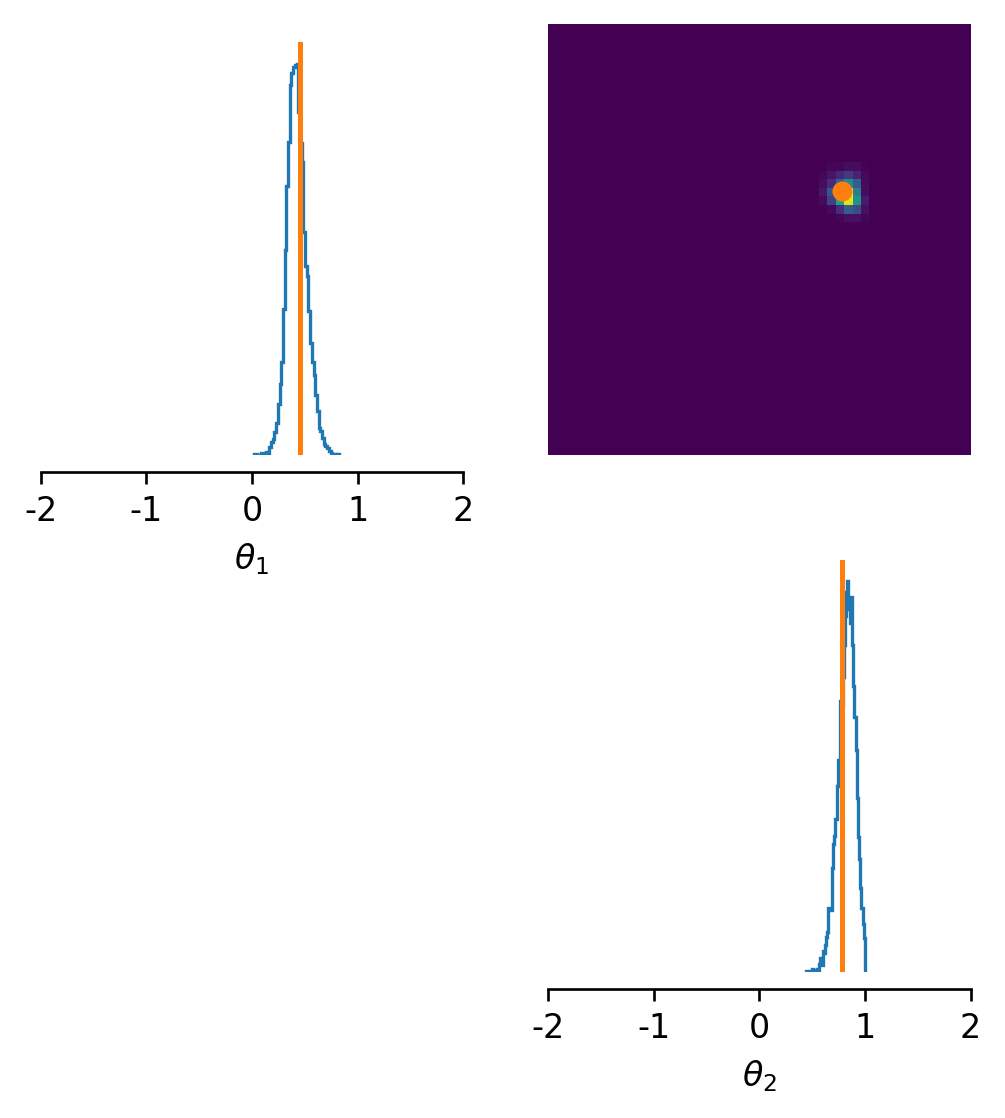

In [55]:
posterior_samples_1 = posterior.sample((10000,), x=x_obs_1)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"], 
    points=theta_1 # add ground truth thetas
)

#### Implemented algorithms

sbi implements powerful machine-learning methods that address this problem. Roughly, these algorithms can be categorized as:

- SNPE: Neural Posterior Estimation (amortized NPE and sequential SNPE),
- SNRE: Neural Ratio Estimation ((S)NRE)
- SNLE: Neural Likelihood Estimation ((S)NLE)


Depending on the characteristics of the problem, e.g. the dimensionalities of the parameter space and the observation space, one of the methods will be more suitable.


In [ ]:
## Try to inference with NLE 

### Use an embedding_net to learn summary features